# Numerical Methods for Manu Body Physics, Assignment #5

Yoav Zack, ID 211677398

In [21]:
using LinearAlgebra
using Statistics
using Plots
using Printf
using LsqFit
using Random
theme(:default)

## Question 1: 1D Quantum TFIM

### 1. Wolff Algorithm

First, we import all of the relevant code from the last assignment, and modify it to include non-isotropic interaction:

In [22]:
struct Lattice2D
    N1::Integer
    N2::Integer
    lattice::Matrix{Int64}
    J1::Real
    J2::Real
    beta::Real
    bc::String
    
    function Lattice2D(N1::Integer, N2::Integer, J1::Real, J2::Real, T::Real, bc::String)
        @assert N1 > 0 "Lattice size must be positive integer"
        @assert N2 > 0 "Lattice size must be positive integer"
        @assert J1 > 0 "Interaction coefficient J1 must be positive"
        @assert J2 > 0 "Interaction coefficient J2 must be positive"
        @assert T > 0 "Temperature must be positive"

        if !(bc in ["periodic", "closed"])
            error("Boundacy conditions are either periodic or closed")
        end
        
        beta = 1. / T
        lattice = rand(0:1, N1, N2)
        new(N1, N2, lattice, J1, J2, beta, bc)
    end
end

In [23]:
function showLattice(lattice::Matrix, T::Real)
    N1 = size(lattice)[1]
    N2 = size(lattice)[2]
    h = heatmap(lattice, c=:nuuk, colorbar=nothing)
    heatmap!(h, xlim=(0.5,N2+0.5), ylim=(0.5,N1+0.5), xticks=0, yticks=0)
    heatmap!(h, aspect_ratio=:equal, frame=:on)
    heatmap!(h, title=@sprintf("N=%d×%d, T=%.2f", N1, N2, T))
    return h
end

showLattice (generic function with 1 method)

In [24]:
function nearestNeighboors(i::Integer, j::Integer, lat::Lattice2D)
    N1 = lat.N1
    N2 = lat.N2
    if lat.bc == "periodic"
        i = (i-1 % N1) + 1
        j = (j-1 % N2) + 1
    end

    @assert i >= 1 && j >= 1 && i <= N1 && j <= N2 "Invalid spin index"
    neighboors = [
        ((i+1,j), "y"),
        ((i-1,j), "y"),
        ((i,j+1), "x"),
        ((i,j-1), "x")
    ]
    
    if lat.bc == "periodic"
        return [( (mod(x-1,N1),mod(y-1,N2)).+1, d ) for ((x,y),d) in neighboors]
    elseif lat.bc == "closed"
        return [((x,y), d) for ((x,y), d) in neighboors if (x>=1) && (y>=1) && (x<=N1) && (y<=N2)]
    else
        error("Invalid boundary condition in nearestNeighboors()")
    end
end

nearestNeighboors (generic function with 1 method)

In [25]:
function selectCluster(i::Integer, j::Integer, lat::Lattice2D)
    cluster = [(i,j)]
    queue = nearestNeighboors(i, j, lat)
    
    spini = lat.lattice[i,j]
    while !isempty(queue)
        (sj, dir) = pop!(queue)
        if sj in cluster
            continue
        end
        spinj = lat.lattice[sj[1], sj[2]]
        @assert dir in ["x", "y"] "Invalid neighboor direction"

        if dir == "y"
            p = 1 - exp(-2*lat.beta*lat.J1)
        else
            p = 1 - exp(-2*lat.beta*lat.J2)
        end
        
        if spini == spinj && rand() < p
            push!(cluster, sj)
            append!(queue, nearestNeighboors(sj[1], sj[2], lat))
        end
    end

    return cluster
end

selectCluster (generic function with 1 method)

In [26]:
function iterationWolff!(lat::Lattice2D)
    i = rand(1:lat.N1)
    j = rand(1:lat.N2)

    cluster = selectCluster(i, j, lat)
    
    for s in cluster
        lat.lattice[s[1], s[2]] = 1 - lat.lattice[s[1], s[2]]
    end
end

iterationWolff! (generic function with 1 method)

In [27]:
function magnetization(lat::Lattice2D)
    m = abs(mean(2 .* lat.lattice .- 1))
    return m
end

magnetization (generic function with 1 method)

In [28]:
function WolffIsing(N1::Integer, N2::Integer, J1::Real, J2::Real, T::Real, Nsw::Integer, bc::String, f=nothing)
    lat = Lattice2D(N1, N2, J1, J2, T, bc)

    m = zeros(Nsw)
    m[1] = magnetization(lat)
    if f != nothing
        @assert typeof(f)<:Function "Invalid function in WolffXY"
        farr = Array{Any}(undef, Nsw)
    end
    
    for i in 2:Nsw
        iterationWolff!(lat)
        m[i] = magnetization(lat)
        if f != nothing
            farr[i] = f(lat)
        end
    end

    if f != nothing
        return lat, m, farr
    else
        return lat, m
    end
end

WolffIsing (generic function with 2 methods)

As a simple test, let's simulate three cases - isotropic, vertical-only and horizontal-only interactions. We will stop the simulation before equalibration, to observe the anisotropy clearly:

In [29]:
# common parameters
N = 32
T = 0.1
Nsw = 2^9

plist = []
@time lat_i, m = WolffIsing(N, Int(3*N/4), 1.0, 1.0, T, Nsw, "periodic")
push!(plist, plot(abs.(m), xaxis="log", title="Isotropic"))
@time lat_x, m = WolffIsing(N, Int(3*N/4), 1.0, 1e-6, T, Nsw, "periodic")
push!(plist, plot(abs.(m), xaxis="log", title="Vertical Interaction"))
@time lat_y, m = WolffIsing(N, Int(3*N/4), 1e-6, 1.0, T, Nsw, "periodic")
push!(plist, plot(abs.(m), xaxis="log", title="Horizontal Interaction"));

  2.620409 seconds (19.07 M allocations: 781.455 MiB, 2.49% gc time, 15.02% compilation time)
  0.094425 seconds (717.41 k allocations: 27.547 MiB)
  0.063552 seconds (567.42 k allocations: 24.080 MiB, 5.59% gc time)


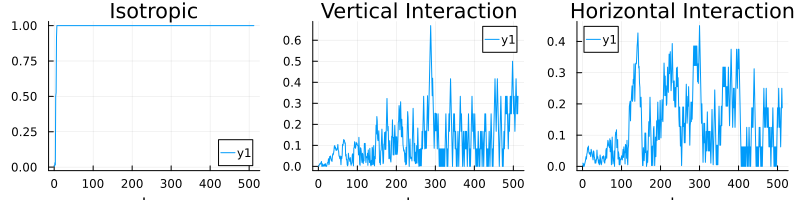

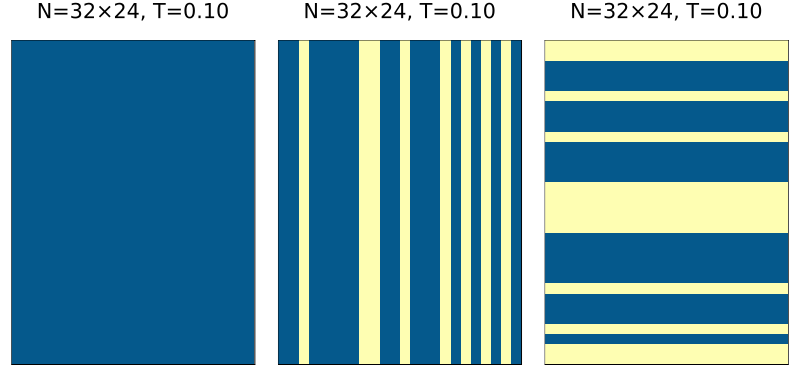

In [30]:
hi = showLattice(lat_i.lattice, T)
hx = showLattice(lat_x.lattice, T)
hy = showLattice(lat_y.lattice, T)
hlist = [hi, hx, hy]
display(plot(plist..., layout=(1,3), size=(800, 200)))
display(plot(hlist..., layout=(1,3), size=(800, 390)))

From these plots we can indeed observe the anisotropy of the model. Now that we know the model works, we will follow section (2) of the question and try to calculate the magnetization of the Q-TFIM as a function of $h/J$, by writing a wrapper that converts a 1D Q-TFIM into a 2D anisotropic Ising model:

In [38]:
function QTFIM(N::Integer, T::Real, J::Real, h::Real, Δτ::Real, f=nothing)
    β = 1/T
    Nx = N
    Nτ = β/Δτ
    @assert Nτ % 1 == 0 "Invalid β/Δτ Values"
    Nτ = Int(Nτ)
    Jx = J*Δτ
    Jτ = 1/2 * log(coth(Δτ*h))

    Nsw = 2^14

    return WolffIsing(Nx, Nτ, Jx, Jτ, 1, Nsw, "periodic", f)
    
end

QTFIM (generic function with 2 methods)

Now we use this wrapper function to simulate the phase transition as instructed:

In [39]:
Nlist = [8, 16, 32]
hlist = range(0.8, stop=1.2, step=.02)
T = 0.1
J = 1.0
Δτ = 0.1

# multithreading
dimN = length(Nlist)
dimh = length(hlist)
dimTotal = dimN * dimh

# log arrays
latlist = Array{Any}(undef, length(Nlist), length(hlist))
mlist = Array{Any}(undef, length(Nlist), length(hlist))

# loop over all required temperatures and sizes
@time Threads.@threads for ind in 1:dimTotal
    # load data from lists
    Nind = mod(ind - 1, dimN) + 1
    hind = Int((ind - Nind)/dimN + 1)
    N = Nlist[Nind]
    h = hlist[hind]

    # simulate
    @time (lat, m) = QTFIM(N, T, J, h, Δτ)

    # log
    latlist[Nind, hind] = lat
    mlist[Nind, hind] = m
end

 74.998518 seconds (1.40 G allocations: 49.376 GiB, 11.71% gc time, 0.75% compilation time)
111.109759 seconds (2.03 G allocations: 71.560 GiB, 11.70% gc time, 0.32% compilation time)
161.089627 seconds (2.89 G allocations: 101.572 GiB, 11.80% gc time, 0.87% compilation time)
 60.515439 seconds (1.04 G allocations: 36.361 GiB, 11.92% gc time)
142.367587 seconds (2.41 G allocations: 84.541 GiB, 11.86% gc time)
219.135374 seconds (3.84 G allocations: 134.931 GiB, 11.79% gc time, 0.52% compilation time)
222.875102 seconds (3.89 G allocations: 136.881 GiB, 11.78% gc time, 0.45% compilation time)
 92.001165 seconds (1.47 G allocations: 51.793 GiB, 11.48% gc time)
103.664543 seconds (1.64 G allocations: 57.798 GiB, 11.27% gc time)
187.996890 seconds (2.98 G allocations: 104.810 GiB, 11.19% gc time)
411.765846 seconds (6.89 G allocations: 242.305 GiB, 11.52% gc time, 0.34% compilation time)
 58.132276 seconds (922.56 M allocations: 32.387 GiB, 11.22% gc time)
 81.354241 seconds (1.21 G alloca

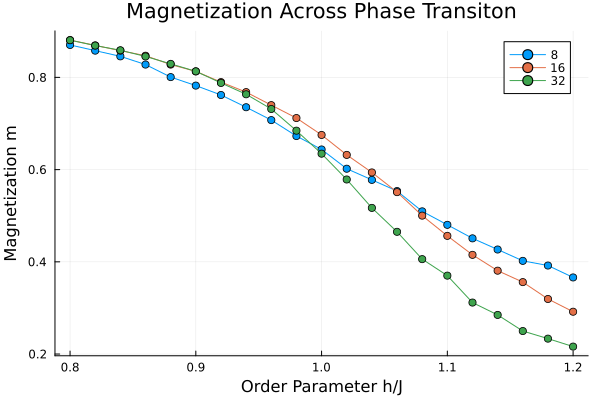

In [40]:
mbar = Array{Real}(undef, dimN, dimh)
for (Nind, N) in enumerate(Nlist)
    for (hind, h) in enumerate(hlist)
        lstart = Int(length(mlist[Nind,hind])/2)
        m = mlist[Nind,hind][lstart:end]
        mbar[Nind, hind] = mean(m)
    end
end

plot(hlist./J, mbar', marker=:circle, label=Nlist', title="Magnetization Across Phase Transiton")
xlabel!("Order Parameter h/J")
ylabel!("Magnetization m")

We can easily observe the drop in $m$ across the phase transition from ferromagnetic to paramagnetic states. Next, we calculate the binder cumulant:

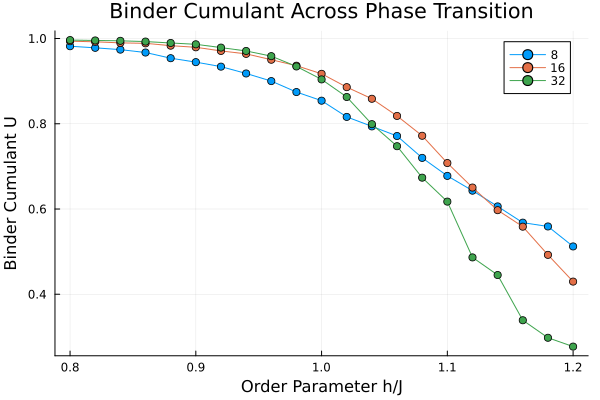

In [41]:
Ubar = Array{Real}(undef, dimN, dimh)
for (Nind, N) in enumerate(Nlist)
    for (hind, h) in enumerate(hlist)
        lstart = Int(length(mlist[Nind,hind])/2)
        m = mlist[Nind,hind][lstart:end]
        Ubar[Nind, hind] = 3/2*(1-1/3*mean(m.^4)/mean(m.^2)^2)
    end
end

plot(hlist, Ubar', marker=:circle, label=Nlist', title="Binder Cumulant Across Phase Transition")
xlabel!("Order Parameter h/J")
ylabel!("Binder Cumulant U")

Sadly we do not get the expected intersection of the plots at $h/J\simeq 1$, but I don't know why. Probably something with the "be careful" warning that has been written in the tutorial, or with the adaptation of the Wolff Algorithm to Anisotropic Lattices.